In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean, threshold_local
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


In [21]:
def serialprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    holes = denoise_tv_chambolle(rank.enhance_contrast(gray, disk(8)), weight=0.3)
    # niblack = holes > threshold_niblack(holes, window_size=61, k=0.9)

    return holes
    return remove_small_holes(img_as_ubyte(niblack), 400)

In [24]:
def numberprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    seed = np.copy(gray)
    seed[1:-1, 1:-1] = gray.max()
    mask = gray

    filled = reconstruction(seed, mask, method='erosion')
    # holes = denoise_wavelet(rank.enhance_contrast(gray-filled+1, disk(6)))
    # niblack = holes > threshold_niblack(holes, window_size=71, k=0.9)
    holes = denoise_wavelet(rank.enhance_contrast(gray-filled+1, disk(6)))
    
    thresh_min = threshold_mean(holes)
    binary_min = holes > thresh_min
    
    filtered_smallest_noise = remove_small_holes(img_as_ubyte(binary_min), 100)
    
    opened = binary_opening(filtered_smallest_noise, disk(2))
    # eroded = binary_erosion(opened, disk(2))
    # eroded = binary_erosion(filtered_smallest_noise, disk(2))
    # eroded = filtered_smallest_noise
    
    # filtered_larger_noise = remove_small_holes(img_as_ubyte(opened), 200)
    filtered_larger_noise = binary_dilation(opened, disk(2))

    return filtered_larger_noise

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


CPU times: user 60.2 ms, sys: 0 ns, total: 60.2 ms
Wall time: 60.1 ms
CPU times: user 0 ns, sys: 16 ms, total: 16 ms
Wall time: 207 ms
553 2 5553


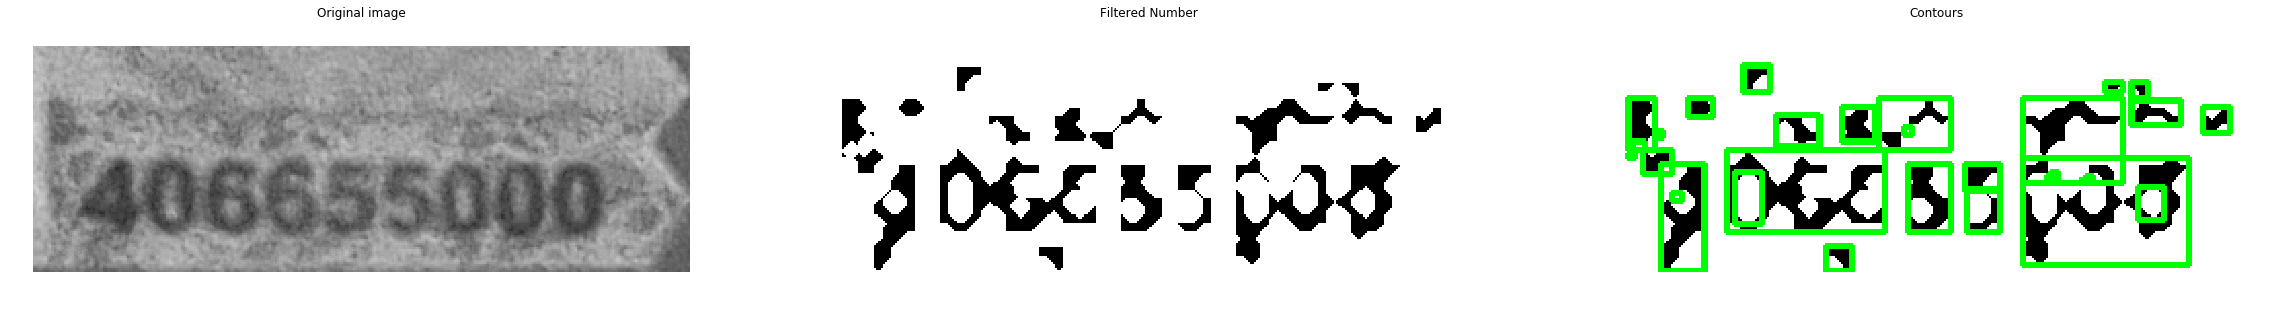

In [26]:

src = Image.open('data/monitor/_1521540628560_capture.png')

number = src.crop((310, 300, 300+330, 310+100))
%time filtered_number = numberprepare(number)
%time numberCandidate = pytesseract.image_to_string(Image.fromarray(filtered_number, "L"), config="--tessdata-dir ./tessdata -psm 8 -oem 3 -l eng -c tessedit_char_whitelist=1234567890 nobatch digits")
thresholded = img_as_ubyte(filtered_number)

edged = cv2.Canny(thresholded, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone = np.dstack([thresholded.copy()] * 3)
 
# loop over the (sorted) contours
for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 3, figsize=(40, 5), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(number)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filtered_number, cmap='gray')
ax[1].set_title('Filtered Number')
ax[1].axis('off')

ax[2].imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contours')
ax[2].axis('off')

print(numberCandidate)

In [3]:
src = Image.open('data/monitor/_1521540628560_capture.png')

image = src.crop((310, 300, 300+330, 310+100))
img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
gray = rgb2gray(img_log_clah)

seed = np.copy(gray)
seed[1:-1, 1:-1] = gray.max()
mask = gray

filled = reconstruction(seed, mask, method='erosion')
holes = rank.enhance_contrast(gray-filled+1, disk(3))

thresh_min = threshold_mean(holes)
binary_min = holes > thresh_min

# block_size = 5
# adaptive_thresh = threshold_local(holes, block_size, offset=1)
# binary_min = holes > adaptive_thresh

# local_otsu = rank.otsu(holes, disk(15))
# region_otsu = holes >= local_otsu

# binary_min = region_otsu

filtered_smallest_noise = remove_small_holes(img_as_ubyte(binary_min), 10)

morph = binary_opening(filtered_smallest_noise, disk(2))
# morph = binary_closing(filtered_smallest_noise, disk(1))
# eroded = binary_erosion(opened, disk(2))
# eroded = binary_erosion(filtered_smallest_noise, disk(2))
# eroded = filtered_smallest_noise

# filtered_larger_noise = remove_small_holes(img_as_ubyte(opened), 200)
filtered_larger_noise = binary_dilation(opened, disk(2))

fig, ax = plt.subplots(2, 4, figsize=(40, 5), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(number)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(gray, cmap='gray')
ax[1].set_title('CLAH')
ax[1].axis('off')

ax[2].imshow(gray-filled, cmap='gray')
ax[2].set_title('Holes')
ax[2].axis('off')

ax[3].imshow(binary_min, cmap='gray')
ax[3].set_title('Threshold')
ax[3].axis('off')

ax[4].imshow(filtered_smallest_noise, cmap='gray')
ax[4].set_title('Filtered')
ax[4].axis('off')

ax[5].imshow(morph, cmap='gray')
ax[5].set_title('Morphology')
ax[5].axis('off')

ax[6].imshow(seed, cmap='gray')
ax[6].set_title('Seed')
ax[6].axis('off')

ax[7].imshow(filled, cmap='gray')
ax[7].set_title('Filled')
ax[7].axis('off')

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


NameError: name 'opened' is not defined

### As you can see, simple filter and morphological changes do not yield significant results.
## Generally this is not bad. From the current moment we can use pure opencv and we have a chance to work out the system on the frontend

In [2]:
def crop_number(input_src):
    return input_src[310:310+100, 300:300+330]

def segment_mumber(excise_src):
    
    number = crop_number(excise_src)
    gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
    clh = clahe.apply(gray)

    # C++ code https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
    #lab_image = cv2.cvtColor(number, cv2.COLOR_RGB2LAB)
    #l, a, b = cv2.split(lab_image)
    #clh2 = clahe.apply(l)

    thresholded = cv2.adaptiveThreshold(cv2.bilateralFilter(clh, 6, 25, 25), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)

    kernel = np.ones((2,2), np.uint8)
    dilated = cv2.dilate(thresholded, kernel, iterations=1)

    edged = cv2.Canny(dilated, 30, 200)
    width, height = dilated.shape[:2]

    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    # refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
    # refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

    # create a clone of the original image so we can draw on it
    clone = np.dstack([dilated.copy()] * 3)
    clone2 = np.dstack([dilated.copy()] * 3)
    #clone3 = np.dstack([gray.copy()] * 3)

    # Top and bottom borders and height
    tb = []
    bb = []
    hgs = []
    first_sorted_cnt = []
    boundingBoxes = [cv2.boundingRect(c) for c in refCnts]

    for c in boundingBoxes:
        # compute the bounding box of the contour and draw it on our
        # image
        (x, y, w, h) = c
        if (w < 100) and (h > 25) and (w > 7) and (h < 90):
            first_sorted_cnt.append(c)
            tb.append(y)
            bb.append(y+h)
            hgs.append(h)
            #cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Sort left to right
    first_sorted_cnt = sorted(first_sorted_cnt, key=lambda x: x[0])

    # Use IQR (85 and 15 percentile)
    tb_iqr = np.percentile(tb, [85, 15])
    bb_iqr = np.percentile(bb, [85, 15])
    hgs_iqr = np.percentile(hgs, [90, 10])

    tlx = 330
    tly = 100
    rbx = 0
    rby = 0

    prewrb = 0

    for c in first_sorted_cnt:
        (x, y, w, h) = c

        tb_iqr_filter = (y <= tb_iqr[0]) and (y >= tb_iqr[1])
        bb_iqr_filter = (y + h <= bb_iqr[0]) and (y + h >= bb_iqr[1])
        height_iqr_filter = (h <= hgs_iqr[0] + 4) and (h >= hgs_iqr[1] - 3)
        prewious_distance_filter = (prewrb == 0) or (x - prewrb < 20)

        if (tb_iqr_filter or bb_iqr_filter) and height_iqr_filter and prewious_distance_filter:
            prewrb = x+w
            tlx = x if x < tlx else tlx
            tly = y if y < tly else tly
            rbx = x+w if x+w > rbx else rbx
            rby = y+h if y+h > rby else rby
            cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 0, 255), 2)
        #else:
        #    print(tb_iqr_filter, bb_iqr_filter, height_iqr_filter, prewious_distance_filter)
        #    print(hgs_iqr)
        #    print(h)

    cv2.rectangle(clone2, (tlx, tly), (rbx, rby), (255, 0, 0), 2)

    return clone, clone2

def display_single_tests():
    fig, ax = plt.subplots(2, 4, figsize=(40, 5), sharex=True, sharey=True)
    ax = ax.ravel()

    ax[0].imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(clh2, cv2.COLOR_GRAY2RGB))
    ax[1].set_title('CLAHE LAB')
    ax[1].axis('off')

    ax[2].imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    ax[3].imshow(cv2.cvtColor(dilated, cv2.COLOR_GRAY2RGB))
    ax[3].set_title('dilated')
    ax[3].axis('off')

    ax[4].imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    ax[4].set_title('Contoured')
    ax[4].axis('off')

    ax[5].imshow(cv2.cvtColor(clone2, cv2.COLOR_BGR2RGB))
    ax[5].set_title('IQR Filtered')
    ax[5].axis('off')

    ax[6].imshow(cv2.cvtColor(clone3, cv2.COLOR_BGR2RGB))
    ax[6].set_title('Number Zone')
    ax[6].axis('off')

    #ax[7].imshow(cv2.cvtColor(dilated[tly:rby, tlx:rbx], cv2.COLOR_GRAY2RGB))
    #ax[7].set_title('Number Zone')
    #ax[7].axis('off')

True False False True


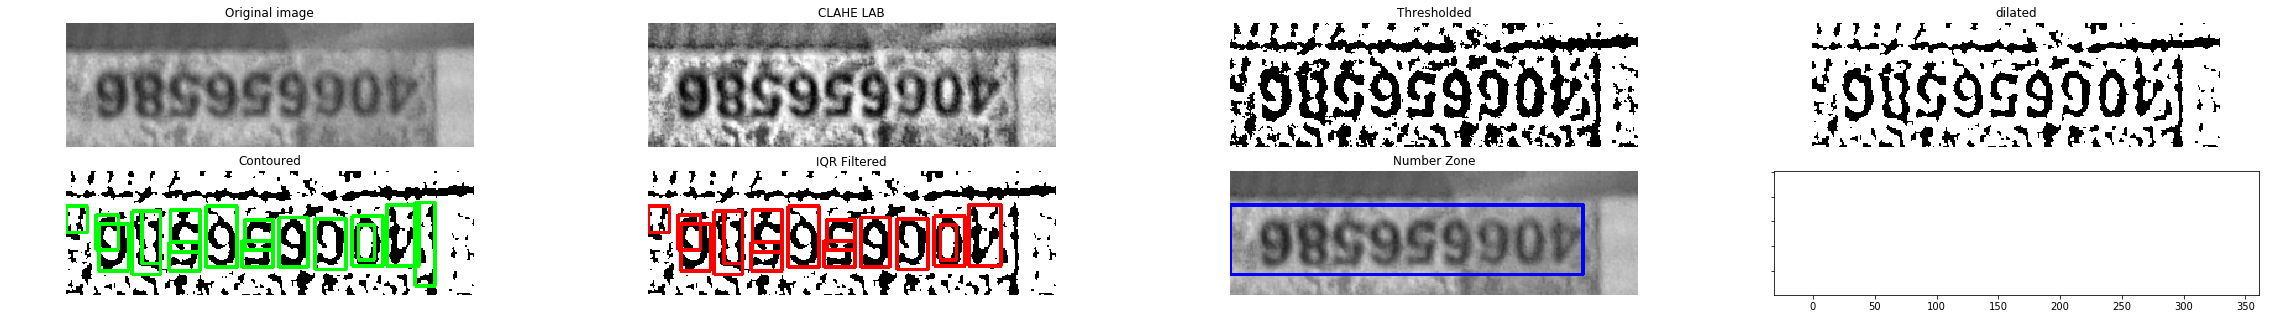

In [6]:
excise_src = cv2.imread("data/monitor/_1521540617554_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540628560_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540613851_capture.png")

number = crop_number(excise_src)
gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
clh = clahe.apply(gray)

# C++ code https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
lab_image = cv2.cvtColor(number, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab_image)
clh2 = clahe.apply(l)

thresholded = cv2.adaptiveThreshold(cv2.bilateralFilter(clh, 6, 25, 25), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)
#blurred = cv2.bilateralFilter(clh, 3, 25, 25)
#_, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((2,2), np.uint8)
dilated = cv2.dilate(thresholded, kernel, iterations=1)

edged = cv2.Canny(dilated, 30, 200)
width, height = dilated.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone = np.dstack([dilated.copy()] * 3)
clone2 = np.dstack([dilated.copy()] * 3)
clone3 = np.dstack([gray.copy()] * 3)

# Top and bottom borders and height
tb = []
bb = []
hgs = []
first_sorted_cnt = []
boundingBoxes = [cv2.boundingRect(c) for c in refCnts]

for c in boundingBoxes:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = c
    if (w < 100) and (h > 20) and (w > 7) and (h < 90):
        first_sorted_cnt.append(c)
        tb.append(y)
        bb.append(y+h)
        hgs.append(h)
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Sort left to right
first_sorted_cnt = sorted(first_sorted_cnt, key=lambda x: x[0])

# Use IQR (85 and 15 percentile)
tb_iqr = np.percentile(tb, [85, 15])
bb_iqr = np.percentile(bb, [85, 15])
hgs_iqr = np.percentile(hgs, [90, 10])

tlx = 330
tly = 100
rbx = 0
rby = 0

prewrb = 0

for c in first_sorted_cnt:
    (x, y, w, h) = c
    
    tb_iqr_filter = (y <= tb_iqr[0] + 4) and (y >= tb_iqr[1] - 4)
    bb_iqr_filter = (y + h <= bb_iqr[0] + 4) and (y + h >= bb_iqr[1] - 4)
    height_iqr_filter = (h <= hgs_iqr[0] + 4) and (h >= hgs_iqr[1] - 4)
    prewious_distance_filter = (prewrb == 0) or (x - prewrb < 20)
    
    if (tb_iqr_filter or bb_iqr_filter) and height_iqr_filter and prewious_distance_filter:
        prewrb = x+w
        tlx = x if x < tlx else tlx
        tly = y if y < tly else tly
        rbx = x+w if x+w > rbx else rbx
        rby = y+h if y+h > rby else rby
        cv2.rectangle(clone2, (x, y), (x + w, y + h), (0, 0, 255), 2)
    else:
        print(tb_iqr_filter, bb_iqr_filter, height_iqr_filter, prewious_distance_filter)
        #print(hgs_iqr)
        #print(h)

cv2.rectangle(clone3, (tlx, tly), (rbx, rby), (255, 0, 0), 2)
        
display_single_tests()

## Tests

100%|██████████| 145/145 [00:15<00:00,  9.25it/s]


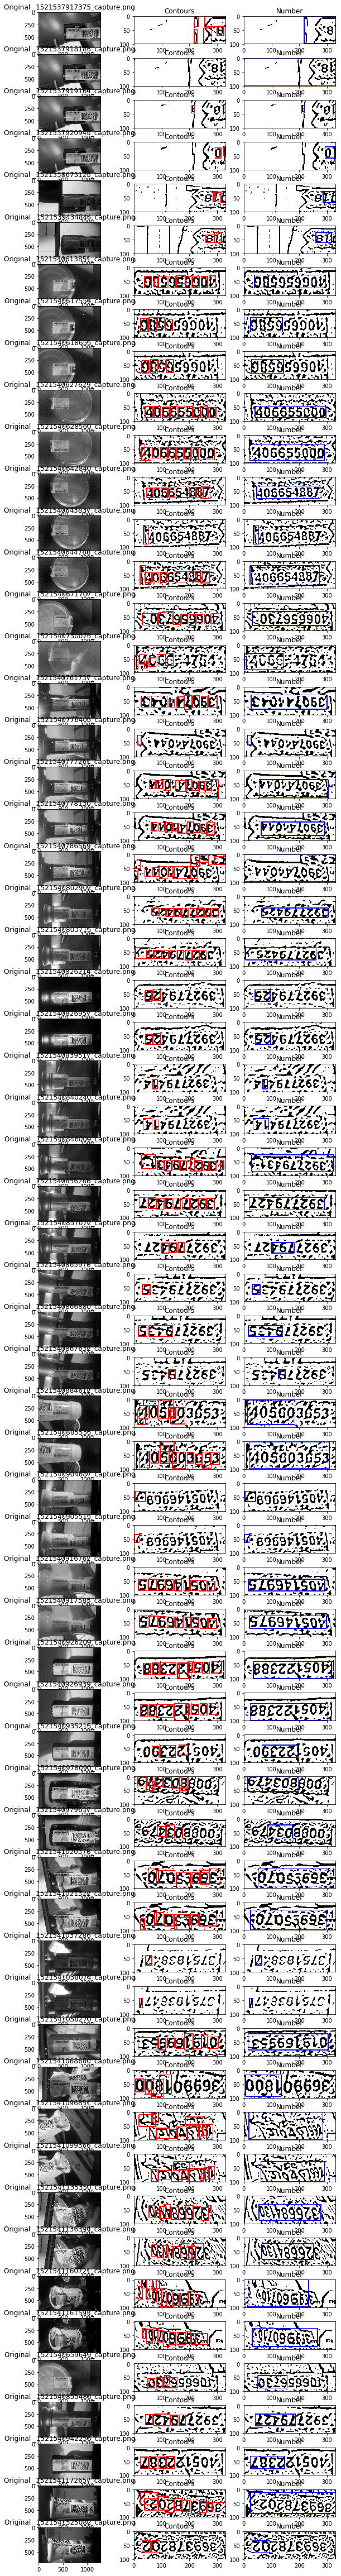

In [249]:
DIR = 'data/monitor'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 200))

for filename in tqdm(os.listdir(DIR)):
    if (not (filename.endswith(".PNG") or filename.endswith(".png"))) or (current_file_index > 60):
        current_file_index += 1
        continue

    input_src = cv2.imread(os.path.join(DIR, filename))

    contour, number = segment_mumber(input_src)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original ' + filename)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(contour, cv2.COLOR_BGR2RGB))
    a.set_title('Contours')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')
    
    current_file_index += 1

plt.show()

In [ ]:
excise_src = cv2.imread("data/monitor/_1521540786569_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540617554_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540917583_capture.png")

# excise_src = cv2.imread("data/monitor/_1521541525082_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540642840_capture.png")

# excise_src = cv2.imread("data/monitor/_1521540926209_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540643837_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540628560_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540613851_capture.png")

number = crop_number(excise_src)
gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
kernel = np.matrix([
        [-0.1, 0.1, -0.1],
        [ 0.1,   2,  0.1],
        [-0.1, 0.1, -0.1]
    ])

bright = cv2.filter2D(gray, -1, kernel)
bright = clahe.apply(bright)

# C++ code https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
clh = clahe.apply(bright)

_, trunc = cv2.threshold(clh, 100, 255, cv2.THRESH_TRUNC)
thresholded = cv2.adaptiveThreshold(trunc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)
# thresholded = cv2.adaptiveThreshold(cv2.bilateralFilter(gray, 6, 25, 25), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)
#blurred = cv2.bilateralFilter(clh, 3, 25, 25)
morphed = thresholded

#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 3))
#morphed = cv2.dilate(thresholded, kernel, iterations=1)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
#morphed = cv2.erode(morphed, kernel, iterations=1)

#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
#connected = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
#morphed = connected

#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 3))
#morphed = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

edged = cv2.Canny(morphed, 30, 200)
width, height = morphed.shape[:2]

#refCnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
refCnts = cv2.findContours(morphed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]

contours = np.dstack([morphed.copy()] * 3)

clone3 = np.dstack([gray.copy()] * 3)

# Top and bottom borders and height
tb = []
bb = []
hgs = []
tlx = 330
tly = 100
rbx = 0
rby = 0

good_mask = np.ones(morphed.shape[:2], dtype="uint8") * 0
good_mask_candidates = []
contour_area = 0

for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    if (w < 100) and (h > 10) and (w > 5) and (h < 90):
        cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 0, 255), 2)
        if (cv2.contourArea(c) > 10):
            first_sorted_cnt.append((x, y, w, h))
            tb.append(y)
            bb.append(y+h)
            hgs.append(h)
            cv2.rectangle(contours, (x, y), (x + w, y + h), (255, 0, 0), 2)
            good_mask_candidates.append(c)
        
for c in good_mask_candidates:
    cv2.drawContours(good_mask, [c], -1, 255, -1)

morphed_inv = cv2.bitwise_not(morphed)
contours_filtered = cv2.bitwise_and(morphed_inv, morphed_inv, mask=good_mask)
colored_contours_filtered = cv2.cvtColor(cv2.bitwise_not(contours_filtered), cv2.COLOR_GRAY2BGR)

for c in good_mask_candidates:
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(colored_contours_filtered, (int(x+w/2-2), int(y+h/2-2)), (int(x + w/2+2), int(y + h/2+2)), (255, 0, 0), 2)

contours2 = np.dstack([contours_filtered.copy()] * 3)
#tb_iqr = np.percentile(tb, [85, 15])
#bb_iqr = np.percentile(bb, [85, 15])
#hgs_iqr = np.percentile(hgs, [90, 10])
#refCnts = cv2.findContours(contours_filtered.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]

#cnt = 0
#print(tb_iqr, bb_iqr)

#for c in refCnts:
#    (x, y, w, h) = cv2.boundingRect(c)
    
#    tb_iqr_filter = (y <= tb_iqr[0] + 2) and (y >= tb_iqr[1] - 2)
#    bb_iqr_filter = (y + h <= bb_iqr[0] + 2) and (y + h >= bb_iqr[1] - 2)
#    height_iqr_filter = (h <= hgs_iqr[0] + 4) and (h >= hgs_iqr[1] - 4)

#    cnt += 1
    
#    #if (w < 100) and (h > 20) and (w > 7) and (h < 90) and (tb_iqr_filter or bb_iqr_filter) and height_iqr_filter:
#    if (tb_iqr_filter or bb_iqr_filter) and cnt > 16:
#        tlx = x if x < tlx else tlx
#        tly = y if y < tly else tly
#        rbx = x+w if x+w > rbx else rbx
#        rby = y+h if y+h > rby else rby
#        cv2.rectangle(contours2, (x, y), (x + w, y + h), (0, 255, 0), 2)
#        print(tb_iqr_filter, bb_iqr_filter)
#        print(y, y + h)
        
cv2.rectangle(clone3, (tlx, tly), (rbx, rby), (255, 0, 0), 2)
        
display_single_tests()